# Compute the geometry of station array and the cross-sections to compute the coseismic strain
2024.01.09 Kurama Okubo

This notebook computes the geometry of station array and cross-sections to compute the strain using [coulomb33](https://www.usgs.gov/publications/coulomb-33-graphic-rich-deformation-and-stress-change-software-earthquake-tectonic-and).


**NOTE:** We use the SRCMOD data of preset file (`SRCMOD_JUL07_v7.mat`) because the mat file download from http://equake-rc.info/SRCMOD/searchmodels/viewmodel/s2004PARKFI01JIxx/ causes an issue associated with `invNoTW`.
`s2004PARKFI01JIxx.mat` set `invNoTW` = 999, which causes the incorrect loop of slip calculation. To avoid that, we used the one from `SRCMOD_JUL07_v7.mat`. Note that the slip profile is identical between those files.



In [1]:
import datetime
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline

from pyproj import Proj # used to convert between utm and lat lon

import numpy as np
import pandas as pd
import h5py
import glob
import pickle

import shutil
from tqdm import tqdm

import matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter

import matplotlib as mpl

# modules to compute distance
import cartopy.geodesic as cgeo


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion


In [2]:
output_imgdir = "../figure/"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    

In [3]:
# read BP station metadata
# read station loc and depth
loc_table = "../data/BP_gmap-stations.txt"
df_raw = pd.read_csv(loc_table, skiprows=3, header=None, sep = '|')

stationidlist = []
for i, row in df_raw.iterrows():
    stationidlist.append("{}.{}".format(row[0], row[1]))
    
dict_loc = {"id": stationidlist,
            "station": df_raw[1],
            "latitude": df_raw[2],
            "longitude": df_raw[3],
            "elevation": df_raw[4],
}
df_locorigin = pd.DataFrame.from_dict(dict_loc)

In [4]:
#make list of station depth
# Instrument depth is available in Malagnini2016 Table 1

stationdepth = {}
stationdepth["EADB"]=245
stationdepth["FROB"]=284
stationdepth["GHIB"]=63
stationdepth["JCNB"]=224
stationdepth["JCSB"]=155
stationdepth["MMNB"]=221
stationdepth["RMNB"]=73
stationdepth["SMNB"]=282 
stationdepth["VARB"]=298 
stationdepth["VCAB"]=200 
stationdepth["CCRB"]=251 
stationdepth["LCCB"]=252 
stationdepth["SCYB"]=252

df_stationdepth = pd.DataFrame(columns=["station", "depth"])
for d in stationdepth:
    df_stationdepth = pd.concat([df_stationdepth, pd.DataFrame({'station': d, 'depth': [stationdepth[d]]})])

df_locorigin = pd.merge(df_locorigin, df_stationdepth, on='station')
df_locorigin = df_locorigin.sort_values(by="station")
df_locorigin

,id,station,latitude,longitude,elevation,depth
0,BP.CCRB,CCRB,35.95718,-120.55158,595.0,251
1,BP.EADB,EADB,35.89522,-120.42262,469.0,245
2,BP.FROB,FROB,35.91095,-120.48688,515.0,284
3,BP.GHIB,GHIB,35.83225,-120.34728,393.0,63
4,BP.JCNB,JCNB,35.93897,-120.43112,533.0,224
5,BP.JCSB,JCSB,35.92117,-120.43400,454.0,155
6,BP.LCCB,LCCB,35.98006,-120.51423,637.0,252
7,BP.MMNB,MMNB,35.95650,-120.49600,701.0,221
8,BP.RMNB,RMNB,36.00087,-120.47772,1164.0,73
9,BP.SCYB,SCYB,36.00942,-120.53661,947.0,252


In [5]:
# Using readlines()
fi = open('../data/historicalfaults.txt', 'r')
lines = fi.readlines()

dict_sf = {}
faultcount = 0
# Strips the newline character
linecount = 0
while linecount < len(lines):
    # initialize fault
    faultcount += 1
    x1 = []
    y1 = []
    while True:
        line = lines[linecount]
        linecount = linecount+1
        if ">" in line:
            dict_sf["fault{:d}".format(faultcount)] = [x1, y1]
            break
        else:
            x1.append(float(line.split("\t")[0]))
            y1.append(float(line.split("\t")[1]))

## Plot stations and fault trace

In [6]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

## Define the approximated straight fault line
We define the fault line to compute the fault normal distance between station and the fault

In [7]:
approx_faultloc = [-120.65, 36.085, -120.35, 35.82] # selected with try and error
# save the location of approximated fault
with open('../data/approx_faultloc.txt', 'w') as f:
#     f.write("lon1, lat1, lon2, lat2\n")
    f.write(f"{approx_faultloc[0]}, {approx_faultloc[1]}\n{approx_faultloc[2]}, {approx_faultloc[3]}")

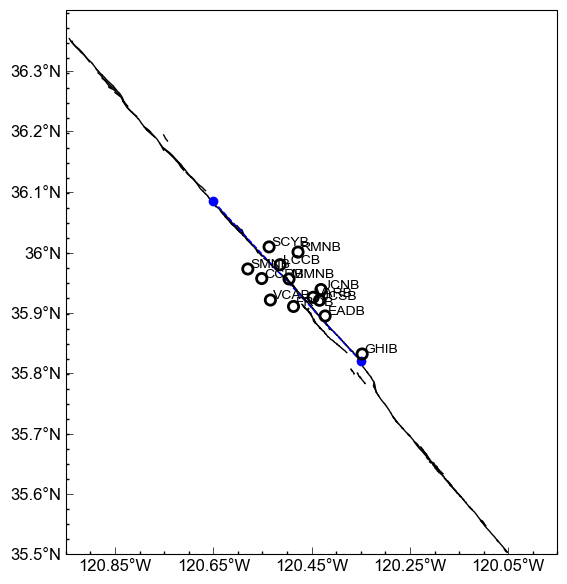

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.95 #-120.625
f_lon_max = -119.95 #-120.3
f_lat_min = 35.5 #35.775
f_lat_max = 36.4 #36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


#---plot fault geometry---#
for sfkey in dict_sf:
    faultx = dict_sf[sfkey][0]
    faulty = dict_sf[sfkey][1]
    min_x, min_y = [np.min(faultx), np.min(faulty)]
    max_x, max_y = [np.max(faultx), np.max(faulty)]

    if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
        ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------#

#---Plot approximated fault loc---#
ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]],
            'bo', ls="--", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.85, -119.95, 0.2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.5, 36.4, 0.1), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()

plt.savefig(output_imgdir+"/BPnetwork_stationloc_cartopy.png", format="png", dpi=300, bbox_inches="tight")


# Compute the cross section

We compute the cross-sections along the approximated fault and the orthogonal line.
We need to convert to xy coordinate to compute the orthogonal line

In [9]:
utm_zone_BP = 10
p = Proj(proj='utm', zone=utm_zone_BP,ellps='WGS84', preserve_units=False)
# x, y = p(lon, lat)


In [10]:
A0 = p(approx_faultloc[0], approx_faultloc[1])
B0 = p(approx_faultloc[2], approx_faultloc[3])

y0 = lambda x: ((B0[1]-A0[1])/(B0[0]-A0[0])) * (x - A0[0]) + A0[1]

In [11]:
C0_k = 0.45
C0_x = A0[0] + C0_k*(B0[0] - A0[0])

In [12]:
C0 = [C0_x, y0(C0_x)]
C0_ll = p(C0[0], C0[1], inverse=True)

In [13]:
C0_ll

(-120.5147526566392, 35.96583440617743)

In [14]:
k1 = -(B0[0]-A0[0])/(B0[1]-A0[1]) # slope of cross-section 
cross_theta = np.arctan(k1)

L = 2e4 #[m]

A1 = [-L*np.cos(cross_theta)+C0[0], -L*np.sin(cross_theta)+C0[1]]
B1 = [L*np.cos(cross_theta)+C0[0], L*np.sin(cross_theta)+C0[1]]

In [15]:
A1, B1

([709744.7027174239, 3969097.118743997],
 [738471.2844605041, 3996932.051856152])

In [16]:
A1_ll = p(A1[0], A1[1], inverse=True)
B1_ll = p(B1[0], B1[1], inverse=True)

In [17]:
A1_ll, B1_ll

((-120.6775808633468, 35.843649386970604),
 (-120.35142385384519, 36.08777545398971))

In [18]:
# Compute location of edges for the coulomb33
# Zero coordinate from s2004PARKFIjich_200f_coulomb.mat
ZERO_LON =  -120.3706
ZERO_LAT = 35.8185

G0 = p(ZERO_LON, ZERO_LAT, inverse=False)

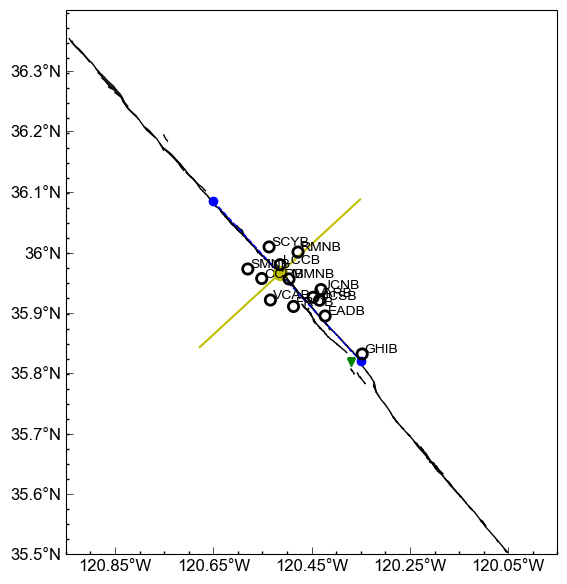

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.Mercator()})
f_lon_min = -120.95 #-120.625
f_lon_max = -119.95 #-120.3
f_lat_min = 35.5 #35.775
f_lat_max = 36.4 #36.07

#---Plot stations---#
for k, row in df_locorigin.iterrows():
    staid = row.id
    sta = row.station
    lon, lat, elevation, depth = row.longitude, row.latitude, row.elevation, row.depth
    ax.scatter(lon,lat, s=55, facecolors='none',  edgecolors='black',
                    linestyle="-", linewidth=2, zorder=6, transform=ccrs.PlateCarree())
    ax.text(lon+0.005, lat+0.001, sta, fontsize=10, transform=ccrs.PlateCarree())


#---plot fault geometry---#
for sfkey in dict_sf:
    faultx = dict_sf[sfkey][0]
    faulty = dict_sf[sfkey][1]
    min_x, min_y = [np.min(faultx), np.min(faulty)]
    max_x, max_y = [np.max(faultx), np.max(faulty)]

    if (min_x > f_lon_min) & (max_x < f_lon_max) & (min_y > f_lat_min) & (max_y < f_lat_max):
        ax.plot(faultx, faulty, 'k', ls="-", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------#

#---Plot approximated fault loc---#
ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]],
            'bo', ls="--", lw=1.0, zorder=-2, transform=ccrs.PlateCarree())
#-------------------------------------------#

#---Plot cross-section---#
ax.plot(C0_ll[0], C0_ll[1], "o", c="y", ms=10, transform=ccrs.PlateCarree())
ax.plot([A1_ll[0], B1_ll[0]], [A1_ll[1], B1_ll[1]], "y-", transform=ccrs.PlateCarree())
ax.plot(ZERO_LON, ZERO_LAT, "gv", transform=ccrs.PlateCarree())

#-------------------------------------------#

ax.set_extent([f_lon_min, f_lon_max, f_lat_min, f_lat_max], crs=ccrs.PlateCarree())

ax.set_xticks(np.arange(-120.85, -119.95, 0.2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(35.5, 36.4, 0.1), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True, dms=False)
lat_formatter = LatitudeFormatter(dms=False)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout()

In [20]:
A1_c = np.array(A1) - np.array(G0)
B1_c = np.array(B1) - np.array(G0)
G0

(737549.8925857826, 3967008.9679012536)

In [21]:
print(f"Start-x:{A1_c[0]/1e3:.7f} Start-y:{A1_c[1]/1e3:.7f} Finish-x:{B1_c[0]/1e3:.7f} Finish-y:{B1_c[1]/1e3:.7f} [km]")


Start-x:-27.8051899 Start-y:2.0881508 Finish-x:0.9213919 Finish-y:29.9230840 [km]


In [22]:
# lat lon of cross-section for gmt
A1_ll, B1_ll

((-120.6775808633468, 35.843649386970604),
 (-120.35142385384519, 36.08777545398971))

# Compute the elastic parameters

We estimated the elastic parameters from the depth profile of the density and P and S wave velocities.

In [23]:
rho = 2569.441457711443
cp  = 5201.496606965174
cs  = 2445.2929950248754

#shear modulus
mu = rho * (cs **2) #[Pa]
# poisson's ratio of rock
vpvs = cp/cs
nu  = 0.5 * (((vpvs**2) - 2.0) / ((vpvs**2) - 1.0))
# Young's modulus of rock
E = 2.0 * mu * (1+nu) # [Pa]

print(f"E:{E/1e5:.3f}bar {E/1e9:.3f}GPa nu:{nu:.5f} mu:{mu/1e9:.3f}GPa")

E:417327.507bar 41.733GPa nu:0.35815 mu:15.364GPa
